In [1]:
import os
import time
import sys
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.backends import cudnn
from torch.nn import functional as F

from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

import load_so_data as so_data
import prob_mod_exploration as explor
import models
import utils
import main

import importlib as imp
imp.reload(models)
imp.reload(utils)
imp.reload(main)
imp.reload(so_data)
# Define data root directory

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Parameters
params = {'batch_size': 256, 'shuffle': True, 'num_workers': 6}
max_epochs = 25

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

window_len = 5*7

common_params = {
    'window_length': window_len,
    'badge_focus': 'Electorate',
    'out_dim': 'QuestionVotes',
    'data_path': '../data'
}

dset_train = so_data.StackOverflowDataset(dset_type='train', subsample=4000, 
                                             **common_params)
dset_test = so_data.StackOverflowDataset(dset_type='test', subsample=1000, 
                                             **common_params)
dset_valid = so_data.StackOverflowDataset(dset_type='validate', subsample=1000, centered=True,
                                             **common_params)

train_loader = DataLoader(dset_train, **params)
test_loader = DataLoader(dset_test, **params)
valid_loader = DataLoader(dset_valid, **params)

In [3]:
len(valid_loader.dataset)

1000

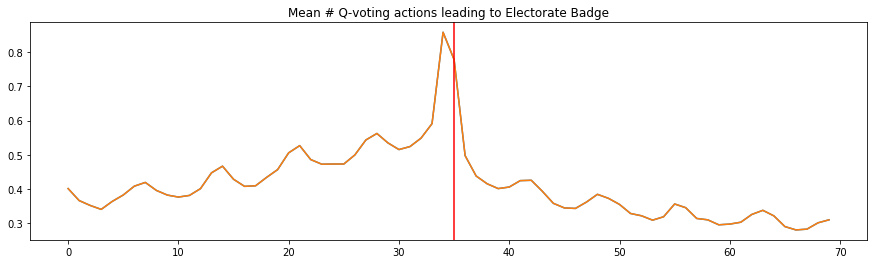

In [4]:
s = np.concatenate([seq.numpy() for seq, kernel, out, prox, badge_date in train_loader], axis=0)
o = np.concatenate([out.numpy() for seq, kernel, out, prox, badge_date in train_loader], axis=0)

plt.figure(figsize=(15,4))
plt.plot(np.mean(s[:,:,5], axis=0))
plt.plot(np.mean(o, axis=0))
plt.axvline(5*7, c='red')
plt.title('Mean # Q-voting actions leading to Electorate Badge')
plt.show()

In [5]:
proximity = []
s = []
for seq, kernel, out, prox, badge_date in train_loader:
    s.append(seq.numpy())
    proximity.append(prox.numpy())
    
proximity = np.concatenate(proximity, axis=0)
s = np.concatenate(s, axis=0)

s.shape, proximity.shape

((4000, 70, 7), (4000, 70))

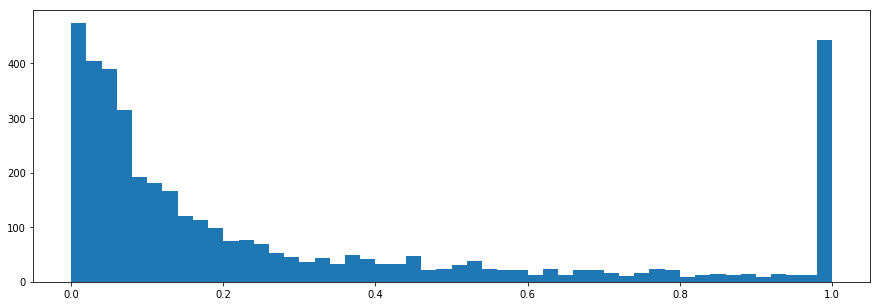

In [6]:
plt.figure(figsize=(15,5))
plt.hist(proximity[:,5*7], bins=50)
plt.show()

In [7]:
# plt.figure(figsize=(15,5))
# for prox in proximity:
#     plt.plot(prox, lw=.5, alpha=.5)
# plt.show()

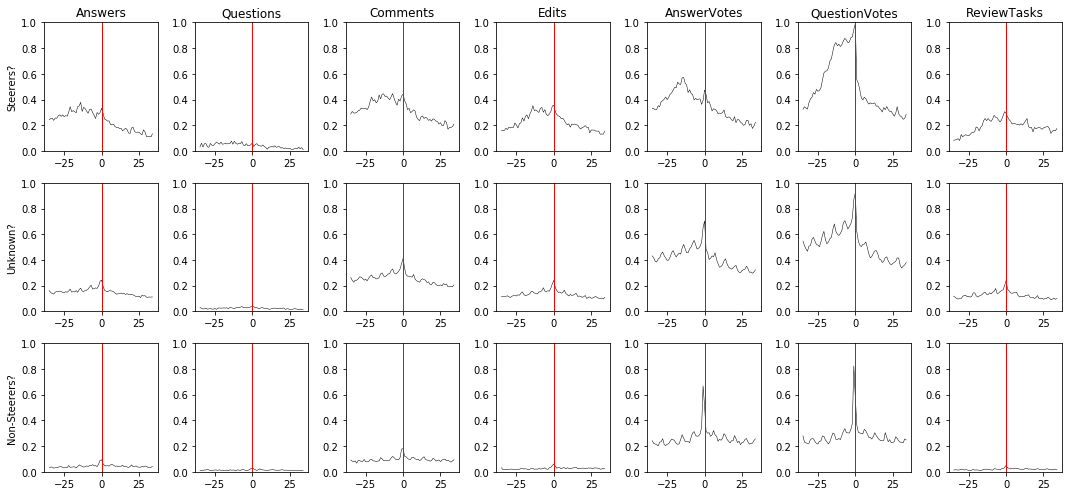

In [8]:
fig, axes = plt.subplots(3,7, figsize=(15,7))

for i in range(7):
    for j in range(3):
        mask = proximity[:,5*7] <= .1
        if j == 0:
            mask = proximity[:,5*7] > .9
        elif j == 1:
            mask = (proximity[:,5*7] <= .9) & (proximity[:,5*7] > .1)
            
        axes[j,i].plot(
                np.arange(-len(proximity[0])//2,len(proximity[0])//2),
                np.mean(s[mask,:,i], axis=0)
            , lw=.5, c='black')
        axes[j,i].axvline(0, c='red', lw=1)
        axes[j,i].set_ylim([0,1])
        
    axes[0,i].set_title(so_data.ACTIONS[i])
    
axes[0,0].set_ylabel('Steerers?')
axes[1,0].set_ylabel('Unknown?')
axes[2,0].set_ylabel('Non-Steerers?')

plt.tight_layout()
plt.show()

## Notes:
    
    - Different populations have different responses to the badge in the proximity of the badge.
    
    - The population that starts with the lowest count of actions (in the 5 week period) has the biggest deviance from 0 in their response

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

In [10]:
def test(model, loss_fn, get_latent_par=[]):
    latent_pars = {}
    latent_pars['steered'] = []
    latent_pars['not_steered'] = []
    with torch.set_grad_enabled(False):
        validation_loss = 0
        for val_in, kernel_data, val_out, val_prox, badge_date in test_loader:
            # Transfer to GPU
            val_in, kernel_data, val_out, val_prox, badge_date = val_in.to(device), \
                            kernel_data.to(device), val_out.to(device), val_prox.to(device), badge_date.to(device)
            # Model computations
            # Model computations
            recon_batch, mu, logvar = model(val_in, kernel_data=kernel_data, dob=badge_date, prox_to_badge=val_prox)

            loss = loss_fn(recon_batch, val_out, mu, logvar)
            validation_loss += loss.item()

            for user_prox, user_mu in zip(val_prox.detach().numpy(), mu.detach().numpy()):
                if np.max(user_prox) > .70:
                    latent_pars['steered'].append(user_mu[-1])
                elif np.max(user_prox) < .1:
                    latent_pars['not_steered'].append(user_mu[-1])
            for p in get_latent_par:
                if p not in latent_pars:
                    latent_pars[p] = []
                latent_pars[p] += [float(mu_.numpy()) for mu_ in mu[:,p]]
        print('Average Test loss: {:.4f}'.format(validation_loss/len(valid_loader.dataset)))
    return latent_pars

In [11]:
dset_shape = dset_train.__getitem__(0)[0].size()
params = {
    'device': device,
    'proximity_to_badge': True
}

In [12]:
def plot_kernel(dset, model, dset_shape, device):
    val_in, kernel_data, val_out, val_prox, badge_date = dset.__getitem__(0)
    val_in, kernel_data, val_out, val_prox, badge_date = val_in.reshape(-1,dset_shape[0],dset_shape[1]).to(device), \
                        kernel_data.reshape(-1,dset_shape[0]).to(device), \
                        val_out.reshape(-1,dset_shape[0]).to(device),     \
                        val_prox.reshape(-1,dset_shape[0]).to(device),    \
                        badge_date.reshape(-1,).to(device)

    recon_batch, mu, logvar = model(val_in, kernel_data=kernel_data, dob=badge_date, prox_to_badge=val_prox)
    k = model.kernel(mu, val_in, kernel_data=kernel_data)
    for k_ in k:
        plt.plot(np.arange(-5*7, 5*7), k_.detach().numpy(), alpha=1)

    plt.axvline(x=0, lw=.5, ls='--', color='black')
    plt.axhline(y=0, lw=.5, ls='--', color='black')
    plt.ylim([-5,5])
    plt.show()

<hr />

<hr />

# Test the different models for accuracy and inspect the various model parameters

## Baseline
Model assumptions:
    
(1) Every user has their own "base distribution".

(2) Base distribution does not change between weeks of interaction.

In [13]:
model = models.BaselineVAE(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/baseline.pt'
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [14]:
loss_fn = lambda x1,x2,x3,x4: models.BCE_loss_function(x1,x2,x3,x4, data_shape=dset_shape, act_choice=5)
_ = test(model, loss_fn)

Average Test loss: 40.8510


## Linear parameter

Model assumptions:
    

(1) Every user has their own "base distribution".

(2) Base distribution does not change between weeks of interaction.

(3) All users experience a linear strictly positive change in probability of acting as they approach the badge boundary. Thereafter they experience a non-positive change in probability in acting. 

In [15]:
model = models.LinearParametricVAE(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/linear.pt'
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

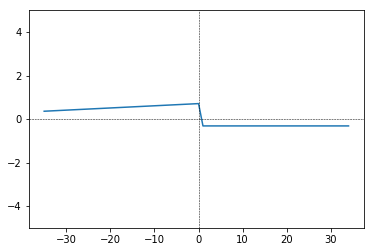

In [16]:
plot_kernel(dset_train, model, dset_shape, device)

In [17]:
loss_fn = lambda x1,x2,x3,x4: models.BCE_loss_function(x1,x2,x3,x4, data_shape=dset_shape, act_choice=5)
_ = test(model, loss_fn)

Average Test loss: 40.1924


## Personalised Linear
Model assumptions - same as Linear but:
    
1) A user-specific steering parameter $\in (0,1)$ that controls the effect of the deviance from normal acting.

In [18]:
model = models.LinearParametricPlusSteerParamVAE(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/personalised_linear.pt'
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

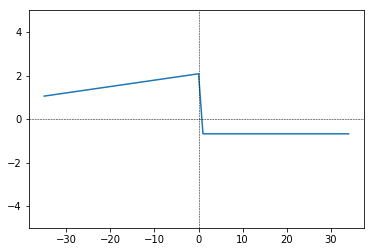

In [19]:
plot_kernel(dset_train, model, dset_shape, device)

In [20]:
loss_fn = lambda x1,x2,x3,x4: models.BCE_loss_function(x1,x2,x3,x4, data_shape=dset_shape, act_choice=5)
ladent_dim = test(model, loss_fn, get_latent_par=[19])

Average Test loss: 39.3136


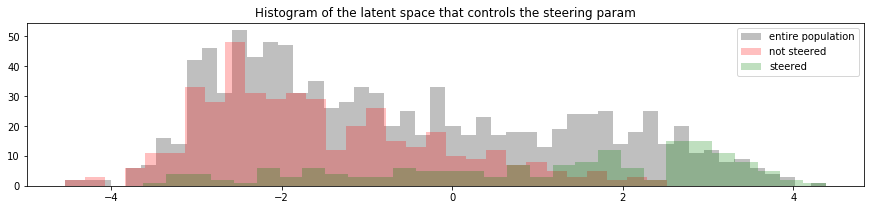

In [21]:
w = model.positive_steer_weight[0].detach().numpy()

plt.figure(figsize=(15,3))
plt.hist(w*ladent_dim[19], label='entire population', bins=50, alpha=.5, color='grey')
plt.hist(w*ladent_dim['not_steered'], label='not steered', alpha=.25, color='red', bins=30)
plt.hist(w*ladent_dim['steered'], label='steered', alpha=.25, color='green', bins=30)
plt.legend(loc='best')
plt.title('Histogram of the latent space that controls the steering param')
plt.show()

# Fully parameterised

Model assumptions:
    

(1) Every user has their own "base distribution".

(2) Base distribution does not change between weeks of interaction.

(3) All users experience a non-negative change in probability of acting before the badge is achieved and a non-positive change in probability of acting before the badge is achieved.


In [22]:
model = models.FullParameterisedVAE(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/full_parameterised.pt'
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

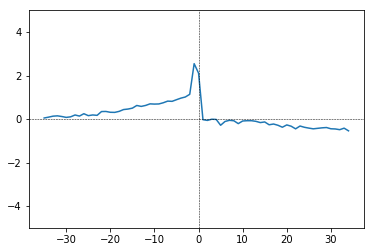

In [23]:
plot_kernel(dset_train, model, dset_shape, device)

In [24]:
loss_fn = lambda x1,x2,x3,x4: models.BCE_loss_function(x1,x2,x3,x4, data_shape=dset_shape, act_choice=5)
_ = test(model, loss_fn)

Average Test loss: 39.2456


# Fully parameterised, personal param
Model assumptions - same as full parameterised but:
    
1) A user-specific steering parameter $\in (0,1)$ that controls the effect of the deviance from normal acting.

In [25]:
model = models.FullParameterisedPlusSteerParamVAE(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/full_personalised_parameterised.pt'
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

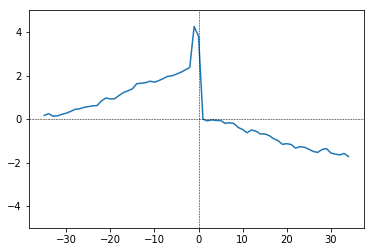

In [26]:
plot_kernel(dset_train, model, dset_shape, device)

In [27]:
loss_fn = lambda x1,x2,x3,x4: models.BCE_loss_function(x1,x2,x3,x4, data_shape=dset_shape, act_choice=5)
ladent_dim = test(model, loss_fn, get_latent_par=[19])

Average Test loss: 38.7116


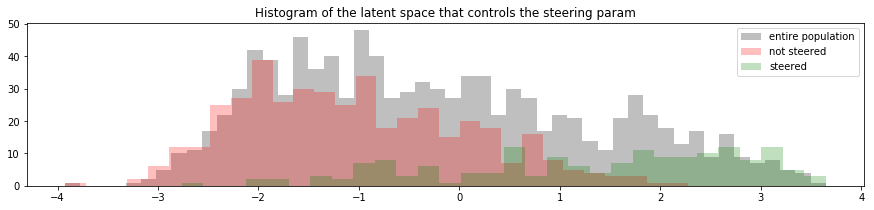

In [28]:
w = model.positive_steer_weight[0].detach().numpy()

plt.figure(figsize=(15,3))
plt.hist(w*ladent_dim[19], label='entire population', bins=50, alpha=.5, color='grey')
plt.hist(w*ladent_dim['not_steered'], label='not steered', alpha=.25, color='red', bins=30)
plt.hist(w*ladent_dim['steered'], label='steered', alpha=.25, color='green', bins=30)
plt.legend(loc='best')
plt.title('Histogram of the latent space that controls the steering param')
plt.show()

# Flexible Linear Parametric

In [29]:
# model = models.FlexibleLinearParametricVAE(dset_shape[0]*dset_shape[1], dset_shape[0], device=device)
# PATH = './models/flexible_linear.pt'
# model.load_state_dict(torch.load(PATH, map_location=device))

# Personalised Flexible Linear

In [30]:
# model = models.FlexibleLinearPlusSteerParamVAE(dset_shape[0]*dset_shape[1], dset_shape[0], device=device)
# PATH = './models/personalised_flexible_linear.pt'
# model.load_state_dict(torch.load(PATH, map_location=device))

# Study the trajectories of the inferences from Full-parameterised model:

In [31]:
latent_pars = {}
latent_pars['steered'] = []
latent_pars['not_steered'] = []
latent_pars['unknown'] = []

with torch.set_grad_enabled(False):
    validation_loss = 0
    for val_in, kernel_data, val_out, val_prox, badge_date in test_loader:
        # Transfer to GPU
        val_in, kernel_data, val_out, val_prox, badge_date = val_in.to(device), \
                        kernel_data.to(device), val_out.to(device), val_prox.to(device), badge_date.to(device)
        # Model computations
        # Model computations
        recon_batch, mu, logvar = model(val_in, kernel_data=kernel_data, dob=badge_date, prox_to_badge=val_prox)

        loss = loss_fn(recon_batch, val_out, mu, logvar)
        validation_loss += loss.item()

        for user_out, user_mu in zip(val_out.detach().numpy(), mu.detach().numpy()):
            if np.max(user_mu[-1]) > .5:
                latent_pars['steered'].append(user_out)
            elif np.max(user_mu[-1]) < -.5:
                latent_pars['not_steered'].append(user_out)
            else:
                latent_pars['unknown'].append(user_out)

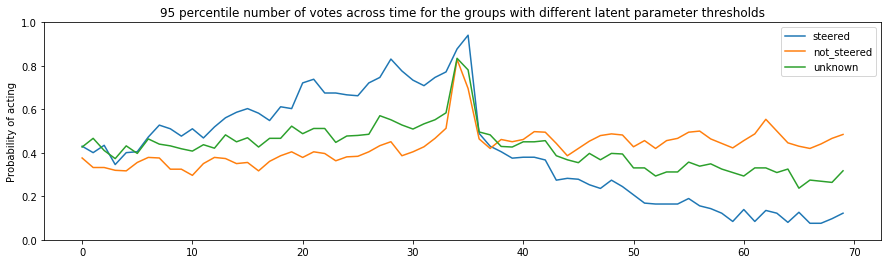

In [32]:
trajs = np.array(latent_pars['steered'])
trajs2 = np.array(latent_pars['not_steered'])
trajs3 = np.array(latent_pars['unknown'])

plt.figure(figsize=(15,4))
plt.plot(np.mean(trajs, axis=0),  label='steered')
plt.plot(np.mean(trajs2, axis=0), label='not_steered')
plt.plot(np.mean(trajs3, axis=0), label='unknown')
plt.title('95 percentile number of votes across time for the groups with different latent parameter thresholds')
plt.legend(loc='best')
plt.ylim([0,1])
plt.ylabel('Probability of acting')
plt.show()